# XAITK-Armory Adversarial Robustness Example <a name="XAITK-Saliency-Armory-Example"></a>
This notebook makes use of the benign (background green screen patch) and adversarial (background noise patch) scenario images generated from the TwoSix team's armory scenario generation [notebook](https://colab.research.google.com/gist/christopherwoodall/8c25aebd5858304046d5ff9a93d5b95d/running_armory_scenarios_interactively.ipynb), and explores generating saliency maps on the patches using ``xaitk-saliency``.

In [1]:
import sys
!{sys.executable} -m pip install -qU pip
!{sys.executable} -m pip install -q xaitk-saliency
!{sys.executable} -m pip install -q torch
!{sys.executable} -m pip install -q torchvision
!{sys.executable} -m pip install -q matplotlib

## Test Images <a name="Test-Images-XAITK-Armory"></a>

Visualization of the armory scenarios with the benign and adversarial patches embedded onto a background building.

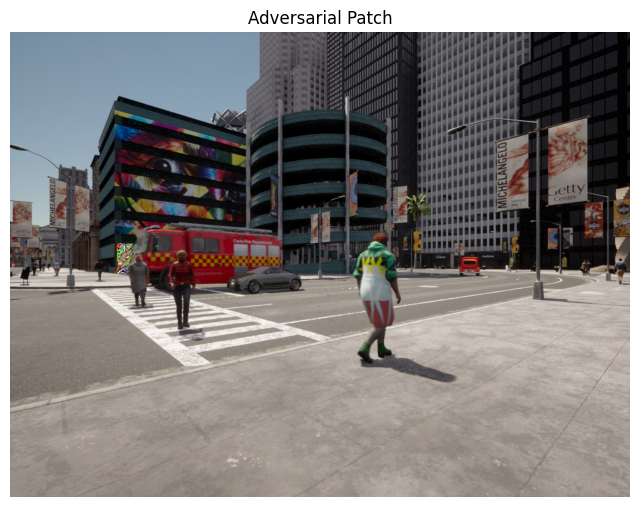

In [2]:
import os
import PIL.Image
import matplotlib.pyplot as plt  # type: ignore
import urllib.request

# Use JPEG format for inline visualizations here.
%config InlineBackend.figure_format = "png"

os.makedirs('data/adversarial-patches', exist_ok=True)
test_benign_image_filename = 'data/adversarial-patches/benign_batch_1.png'
plt.figure(figsize=(8, 8))
plt.title("Benign Patch")
plt.axis('off')
target_benign = PIL.Image.open(test_benign_image_filename)
_ = plt.imshow(target_benign)
test_adversarial_image_filename = './data/adversarial-patches/adversarial_batch_1.png'
plt.figure(figsize=(8, 8))
plt.title("Adversarial Patch")
plt.axis('off')
target_adversarial = PIL.Image.open(test_adversarial_image_filename)
_ = plt.imshow(target_adversarial)

## Load Custom SMQTK wrapped Armory FRCNN model <a name="Load-Model-XAITK-Armory"></a>

The cell below loads in the FRCNN-Resnet50 weights from the ``armory`` pretrained model using a custom version of the SMQTK ResNetFRCNN wrapper (``armory_smqtk_detect_objects.py``)

In [3]:
from armory_smqtk_detect_objects import ResNetFRCNN # type: ignore

detector = ResNetFRCNN(
    box_thresh=0.5,
    img_batch_size=1,
    use_cuda=False
)

## Generate and Visualize Model Detections <a name="Generate-Detections-XAITK-Armory"></a>
We visualize the detections from the ``armory`` model on the benign and adversarial image samples from the same scenario. The custom classes for this model are ``1 - person``, ``2 - vehicle`` and ``3 - traffic light``.

/home/local/KHQ/emily.veenhuis/Documents/jatic/xaitk-jatic/venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:152: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


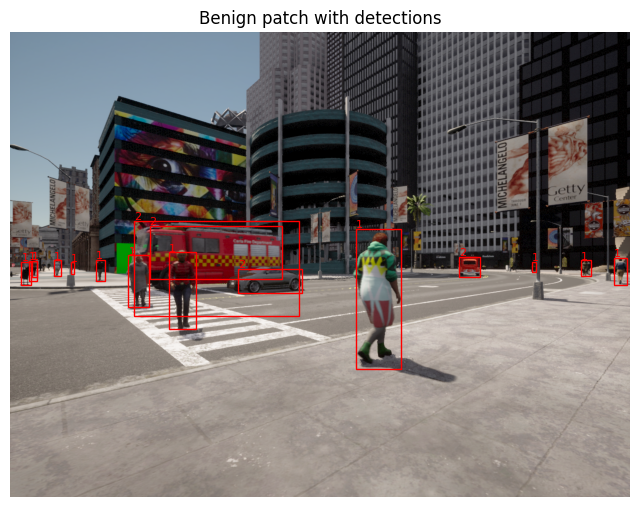

In [4]:
import numpy as np
from matplotlib.patches import Rectangle  # type: ignore

class_ids = {'person': '1', 'vehicle': '2', 'traffic light':'3'}

def show_dets(ax, dets, thresh=0.5, show_labels=True):
    for i, det in enumerate(dets):
        score_dict = det[1]
        cls_name = max(score_dict, key=score_dict.get)
        conf = score_dict[cls_name]
        
        if conf >= thresh:
            bbox = det[0]
            x1, y1 = bbox.min_vertex
            x2, y2 = bbox.max_vertex
            ax.add_patch(Rectangle(
                (x1, y1),
                x2 - x1,
                y2 - y1,
                linewidth=1,
                edgecolor='r',
                facecolor='none'
            ))

            if show_labels:
                label=f'{class_ids[cls_name]}'
                ax.text(x1, y1 - 2, label, color='r', fontsize=8)

# Display detections
img_benign = np.asarray(target_benign)
dets = list(detector([img_benign]))[0]
fig, axs = plt.subplots(figsize=(8, 8))
axs.set_title(f"Benign patch with detections")  # type: ignore
axs.imshow(img_benign)  # type: ignore
axs.axis("off")  # type: ignore
show_dets(axs, dets, thresh=0.4)

img = np.asarray(target_adversarial)
dets = list(detector([img]))[0]
fig, axs = plt.subplots(figsize=(8, 8))
axs.set_title(f"Adversarial patch with detections")  # type: ignore
axs.imshow(img)  # type: ignore
axs.axis("off")  # type: ignore
show_dets(axs, dets, thresh=0.4)

## Prepare Inputs for Saliency Generation <a name="Prepare-Inputs-XAITK-Armory"></a>
The ``GenerateObjectDetectorBlackboxSaliency`` interface requires our reference detections to be split into separate bounding boxes and scores inputs.

In [5]:
def dets_to_mats(dets):
    
    labels = list(dets[0][1].keys())
    bboxes = np.empty((0, 4))
    scores = np.empty((0, 3))

    for det in dets:
        bbox = det[0]
        
        bboxes = np.vstack((
            bboxes,
            [*bbox.min_vertex, *bbox.max_vertex]
        ))

        score_dict = det[1]
        
        score_array = []
        for l in labels:
            score_array.append(score_dict[l])
            
        scores = np.vstack((
            scores,
            score_array
        ))

    return bboxes, scores, labels

## Generate and Visualize Saliency Maps <a name="Generate-Saliency-XAITK-Armory"></a>

Generate saliency maps for specific detection indices and cropping the image down to the specific detection saliency visualizations.

In [6]:
from xaitk_saliency.interfaces.gen_object_detector_blackbox_sal import GenerateObjectDetectorBlackboxSaliency
from smqtk_detection.interfaces.detect_image_objects import DetectImageObjects
from xaitk_saliency.impls.gen_object_detector_blackbox_sal.drise import DRISEStack

def visualize_saliency_plot(title: str,
                            ref_image: np.ndarray, 
                            sal_maps: np.ndarray,
                            ref_bboxes, 
                            labels):
    
    gray_img = np.asarray(PIL.Image.fromarray(ref_image).convert("L"))
    pad_perc = 0.4

    n = len(sal_maps)

    fig, axs = plt.subplots(1, n, figsize=(8,4))

    for i, ax in enumerate(axs):

        try:
            sal_map = sal_maps[i]
        except IndexError:
            ax.axis('off')
            continue

        x1, y1, x2, y2 = ref_bboxes[i]
        pad_x = pad_perc * (x2 - x1)
        pad_y = pad_perc * (y2 - y1)
        x1 = max(int(x1 - pad_x),0)
        y1 = max(int(y1 - pad_y), 0)
        x2 = int(x2 + pad_x)
        y2 = int(y2 + pad_y)

        img_crop = gray_img[y1:(y2+1), x1:(x2+1)]
        sal_crop = sal_map[y1:(y2+1), x1:(x2+1)]

        ax.imshow(img_crop, alpha=0.7, cmap='gray')
        ax.imshow(sal_crop, alpha=0.3, cmap='jet')
        ax.axes.get_xaxis().set_ticks([])
        ax.axes.get_yaxis().set_ticks([])
        ax.set_xlabel(labels[i])

            
    axs = fig.subplots()
    axs.set_title(title, fontsize=15)  # type: ignore
    _ = axs.axis('off')  # type: ignore

def run_detect_saliency(input_img: np.ndarray, 
                        ref_bboxes, 
                        ref_scores):
    
    sal_generator = DRISEStack(
            n=100,
            s=16,
            p1=0.8,
            seed=0,
            threads=8
        )
    
    model_mean = [0.485, 0.456, 0.406]
    sal_generator.fill = np.uint8(np.asarray(model_mean) * 255).tolist()
    
    sal_maps = gen_det_saliency(input_img, detector, sal_generator,ref_bboxes,ref_scores)
    print(f"Saliency maps: {sal_maps.shape}")
    
    return sal_maps

def gen_det_saliency(input_img: np.ndarray,
    blackbox_detector: DetectImageObjects,
    sal_map_generator: GenerateObjectDetectorBlackboxSaliency,
    ref_bboxes: np.ndarray,
    ref_scores: np.ndarray
):
    sal_maps = sal_map_generator.generate(
        input_img,
        ref_bboxes,
        ref_scores,
        blackbox_detector,
    )

    return sal_maps

### Benign Patch Saliency <a name="Generate-Saliency-Adversarial-Patch-XAITK-Armory"></a>

Visualization of the largest foreground objects saliency on the benign image.

Saliency maps: (3, 960, 1280)


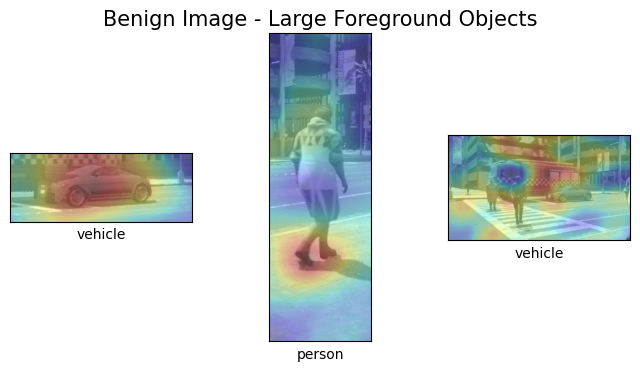

In [7]:
dets = list(detector([img_benign]))[0]
ref_idxs = [6,7,8]
ref_dets = [list(dets)[idx] for idx in ref_idxs]
ref_bboxes, ref_scores, labels = dets_to_mats(ref_dets)
sal_maps = run_detect_saliency(img_benign,ref_bboxes,ref_scores)
final_labels = []
for i in ref_scores:
    lbl = np.where(i == max(i))
    final_labels.append(labels[int(lbl[0])])
visualize_saliency_plot("Benign Image - Large Foreground Objects", img_benign, sal_maps, ref_bboxes, final_labels)

### Adversarial Patch Saliency <a name="Generate-Saliency-Adversarial-Patch-XAITK-Armory"></a>

Visualization of the background attack patch objects (small objects) saliency with the misclassified class names on the adversarial image.

Saliency maps: (3, 960, 1280)


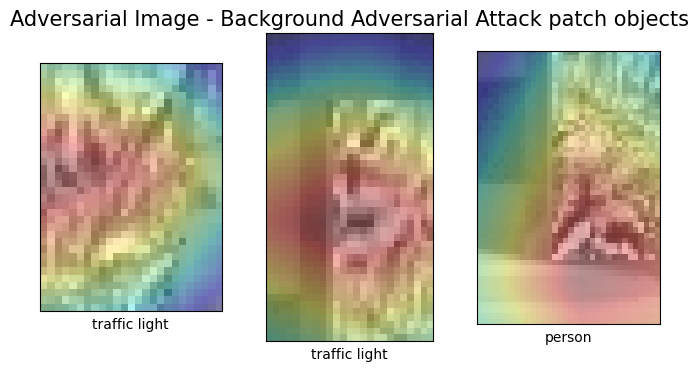

In [8]:
dets = list(detector([img]))[0]
ref_idxs = [0,1,9]
ref_dets = [list(dets)[idx] for idx in ref_idxs]
ref_bboxes, ref_scores, labels = dets_to_mats(ref_dets)
sal_maps = run_detect_saliency(img,ref_bboxes,ref_scores)
final_labels = []
for i in ref_scores:
    lbl = np.where(i == max(i))
    final_labels.append(labels[int(lbl[0])])
visualize_saliency_plot("Adversarial Image - Background Adversarial Attack patch objects", img, sal_maps, ref_bboxes, final_labels)